_Clone before play/engineer with Features / Hyperparameters_

Process to test new features:

1. Add new Features in cell Feature Engineering
2. Go into Preprocessing and add the features in either num, log or cat
3. Run the RandomSearch // Hyperparameter Tuning for at least HGB and RF and see if MAE gets improved compared to previous results
4. If MAE gets not improved, comment in cell below Feature Engineering that you tested those features (+results?) and on which Models - and remove everything
5. If MAE gets improved, find out via Feature Importance (Shap Values) which Feature was responsible + document it, remove the other features that have negative impact
6. comment below the Hyperparameter Tuning cell of the model the new achieved results + all the features you used for that + the hyperparameters
7. save the results in a new model with joblib, name it correctly
8. push to kaggle
9. push to GIT + document everything

# Project Cars4you (Group 5)

### 1. Import & load Data

In [33]:
pip install kaggle

SyntaxError: invalid syntax (4074488566.py, line 2)

In [34]:
# Import and load Data

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import shap


from sklearn.feature_selection import VarianceThreshold, RFE, chi2, RFECV
from scipy.stats import spearmanr, uniform, loguniform, randint
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.svm import SVR

from data_cleaning import clean_car_dataframe

df_cars_train = pd.read_csv("train.csv")
df_cars_test = pd.read_csv("test.csv")

In [3]:
# Kaggle API Connect => everyone has to do this himself, with his own kaggle.json api token

# Folder containing kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "/Workspace/Users/20250355@novaims.unl.pt"

# Test
!echo $KAGGLE_CONFIG_DIR

/Workspace/Users/20250355@novaims.unl.pt


### 2. Data Cleaning, Feature Engineering, Split & Preprocessing

Task II (5 Points): Clean and preprocess the dataset. 
- Missing Value handling, Outlier preprocessing + justify decisions -> in data_cleaning.py
- Review current features and create extra features if needed + explain -> in Feature Engineering
- Deal with categorical variables -> In One-Hot-Encoding 
- Perform data scaling, explain reasoning -> In Transforming

In [10]:
# Outlier Preprocessing, Missing Value Handling and Decision justifying happens here
df_cars_train = clean_car_dataframe(df_cars_train)
df_cars_test = clean_car_dataframe(df_cars_test)


# Safety Check: print unique values of all columns of df_cars_train // df_cars_test to see if data cleaning worked and if there are still odd values
for col in df_cars_train.columns:
    print(col, df_cars_train[col].unique())
print("X"*150)
print("-"*150)
print("X"*150)
for col in df_cars_test.columns:
    print(col, df_cars_test[col].unique())

Brand ['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'Hyundai' nan]
model ['golf' 'yaris' 'q2' 'fiesta' '2 series' '3 series' 'a3' 'octavia'
 'passat' 'focus' 'insignia' 'a class' 'q3' 'fabia' 'ka+' 'glc class'
 'i30' 'c class' 'polo' 'e class' 'q5' 'up' 'c-hr' 'mokka' 'corsa' 'astra'
 'tt' '5 series' 'aygo' '4 series' nan 'ecosport' 'tucson' 'x-class'
 'cl class' 'ix20' 'i20' 'a1' 'auris' 'sharan' 'adam' 'x3' 'a8'
 'gls class' 'b-max' 'a4' 'kona' 'i10' 's-max' 'x2' 'crossland x' 'tiguan'
 'a5' 'gle class' 'zafira' 'ioniq' 'a6' 'mondeo' 'yeti' 'x1' 'scala'
 's class' '1 series' 'kamiq' 'kuga' 'q7' 'gla class' 'arteon' 'sl class'
 'santa fe' 'grandland x' 'rav4' 'touran' 'corolla' 'b class' 'kodiaq'
 'v class' 'superb' 'combo life' 'beetle' 'm3' 'x4' 'ix35' 'm4' 'z4' 'x5'
 'meriva' 'verso' 'cls class' 'c-max' 'puma' 'i40' '6 series' 'karoq' 'a7'
 'land cruiser' 'edge' 'x6' '8 series' 'scirocco' 'z3' 'hilux' 'amarok'
 '7 series' 'avensis' 'm class' 'r8' 'antara' 'q8' 'x7' '

In [11]:
# Feature Engineering and Explaination

# add column age: models can easier interpret linear numerical features
df_cars_train['age'] = 2025 - df_cars_train['year']
df_cars_test['age'] = 2025 - df_cars_test['year']


# miles per year: normalizes the total mileage by how old the car is
df_cars_train['miles_per_year'] = df_cars_train['mileage'] / df_cars_train['age'].replace({0: np.nan})
df_cars_train['miles_per_year'] = df_cars_train['miles_per_year'].fillna(df_cars_train['mileage'])

df_cars_test['miles_per_year'] = df_cars_test['mileage'] / df_cars_test['age'].replace({0: np.nan})
df_cars_test['miles_per_year'] = df_cars_test['miles_per_year'].fillna(df_cars_test['mileage'])


# model frequency: some models are more common, which means they can be cheaper (supply) or retain their values better (demand). freq shows their popularity
model_freq = df_cars_train['model'].value_counts(normalize=True).to_dict()
df_cars_train['model_freq'] = df_cars_train['model'].map(model_freq)
df_cars_test['model_freq'] = df_cars_test['model'].map(model_freq)


# brand median price (only train): shows brand positioning (e.g. BMW > KIA)
brand_median_price = df_cars_train.groupby('Brand')['price'].median()
df_cars_train['brand_med_price'] = df_cars_train['Brand'].map(brand_median_price)
df_cars_test["brand_med_price"] = df_cars_test["Brand"].map(brand_median_price)


# model median price (only train): shows model positioning (e.g. 3er > 1er)
model_med_price = df_cars_train.groupby('model')['price'].median()
df_cars_train['model_med_price'] = df_cars_train['model'].map(model_med_price)
df_cars_test["model_med_price"] = df_cars_test["model"].map(model_med_price)

# brand anchor (market position) 
brand_median_price = df_cars_train.groupby("Brand")["price"].median().to_dict()
overall_mean_price = df_cars_train["price"].mean()

df_cars_train["brand_anchor"] = df_cars_train["Brand"].map(brand_median_price) / overall_mean_price
df_cars_test["brand_anchor"]  = df_cars_test["Brand"].map(brand_median_price) / overall_mean_price

In [6]:
# Put all engineered features that didn't positively affect MAE for HGB or RF at all here:



In [12]:
# Split Data, Stratify not necessary due to regression problem and Cross Validation later
X = df_cars_train.drop(columns='price')
y = df_cars_train['price']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 42, 
                                                  shuffle = True)

In [13]:
# Write custom GroupMedianImputer to impute missing values on a model, brand level and not only global (with SimpleImputer)
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    """
    Impute missing numeric values using hierarchical medians:
    1. By (Brand, model)
    2. If model missing → by Brand
    3. Fallback → global median
    """

    def __init__(self, group_cols=["Brand", "model"]):
        self.group_cols = group_cols

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.feature_names_in_ = X.columns

        # Step 1 — model-level medians
        if all(c in X.columns for c in self.group_cols):
            self.medians_ = X.groupby(self.group_cols).median(numeric_only=True)
        else:
            self.medians_ = pd.DataFrame()

        # Step 2 — brand-level medians
        if "Brand" in X.columns:
            self.brand_medians_ = X.groupby("Brand").median(numeric_only=True)
        else:
            self.brand_medians_ = pd.DataFrame()

        # Step 3 — global medians
        self.global_median_ = X.median(numeric_only=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            if X[col].isna().sum() == 0:
                continue

            # (Brand, model) level
            if all(c in X.columns for c in self.group_cols):
                X[col] = X.apply(
                    lambda r: self.medians_.loc[(r["Brand"], r["model"]), col]
                    if (r["Brand"], r["model"]) in self.medians_.index and pd.isna(r[col])
                    else r[col],
                    axis=1
                )

            # Brand-only fallback
            if "Brand" in X.columns:
                X[col] = X.apply(
                    lambda r: self.brand_medians_.loc[r["Brand"], col]
                    if r["Brand"] in self.brand_medians_.index and pd.isna(r[col])
                    else r[col],
                    axis=1
                )

            # Global fallback
            X[col] = X[col].fillna(self.global_median_[col])

        return X.values  # sklearn expects ndarray

In [14]:
# Preprocessing: with sklearn Pipeline & Column Transformer

group_imputer = GroupMedianImputer(group_cols=["Brand", "model"])

numeric_features = ["age", "tax", "mpg", "engineSize", "paintQuality", "previousOwners", "brand_anchor"]
log_features = ["mileage", "miles_per_year", "model_freq", "brand_med_price", "model_med_price"] # could try to test previousOwners, age here; tax, mpg didnt work
categorical_features = ["Brand", "model", "transmission", "fuelType"]

# left out columns: year (age is better), hasDamage (unsure what the two values 0 and NaN mean)

def to_float_array(x):
    """Convert input to float array."""
    return np.array(x, dtype=float)

log_transformer = Pipeline([
    ("group_impute", GroupMedianImputer(group_cols=["Brand", "model"])),  # Handling of missing numerical values with GroupMedianImputer
    ("to_float", FunctionTransformer(to_float_array)),
    ("log", FunctionTransformer(np.log1p, validate=False)), # log1p handles zeros safely
    ("scaler", StandardScaler()) #  # Data Scaling with sklearn StandardScaler
])

numeric_transformer = Pipeline([
    ("group_impute", GroupMedianImputer(group_cols=["Brand", "model"])),
    ("to_float", FunctionTransformer(to_float_array)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), # fill by mode instead of Unknown (a diesel 3er BMW is probably a diesel)
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # Deal with Categorical Variables with sklearn OneHotEncoder
])

# Apply the preprocessing steps to the data with ColumnTransformer
preprocessor = ColumnTransformer([
    ("log", log_transformer, log_features),
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


# Fit preprocessor on training data - avoid data leakage
preprocessor.fit(X_train)



""" EXPLAINATIONS """
# 1) Pipeline bundles preprocessing + model training:
#       > Ensures all preprocessing happens inside cross-validation folds (no data leakage)
#       > Keeps the entire workflow reproducible — scaling, encoding, and modeling are learned together
#       > After .fit(), the final model automatically knows how to preprocess new unseen data
#       > When saving with joblib, the entire preprocessing (imputers, scalers, encoders) and model are stored together

# 2) The ColumnTransformer applies different transformations to subsets of features:
#       > Numeric Features arehandled by our custom GroupMedianImputer (domain-aware filling)
#           - Missing numeric values are imputed hierarchically:
#           1. By (Brand, model)
#           2. If missing model by Brand
#           3. If missing Brand by global median
#       > This approach captures brand/model-level patterns (e.g. BMWs have similar engine sizes)
#       > After imputation, StandardScaler standardizes all numeric features
#
#       > Log Features use the same group-median imputation, followed by log1p() transformation
#           - log1p() compresses large, skewed values (like mileage or price-related features), stabilizing variance and helping linear models perform better
#           - StandardScaler then scales them to zero mean and unit variance
#
#       > Categorical Features are handled by SimpleImputer + OneHotEncoder
#           - SimpleImputer fills missing categorical values with the most frequent (mode) value.
#             (Alternative would be “Unknown”, but mode keeps categories realistic, e.g. most cars in a model share the same transmission)
#           - OneHotEncoder converts each categorical label (Brand, model, etc.) into binary dummy variables
#             This lets the model use category information numerically without implying order
#
# 3) Overall:
#       > The pipeline ensures consistent preprocessing across training, validation, and test data.
#       > It combines domain knowledge (brand/model-aware imputation) with robust numerical scaling.
#       > Linear models (ElasticNet, Ridge, Lasso) and tree models (HistGradientBoosting, RandomForest)
#           can now learn from the same standardized, clean, and information-rich feature space.

' EXPLAINATIONS '

### 3. Feature Selection

Task III (3 Points): Define and Implement a clear and unambiguous strategy for feature selection. Use the methods **discussed in the course**. Present and justify your final selection 

Model independent Filter Methods:
- Remove constant numerical variables with VarianceThreshold
- Check highly correlated numerical variables and keep one with Spearman
- Remove unindependent categorical variables with Chi2

Model dependent Wrapper Methods:
- RFE LR / RFE SVR for linear Models: ElasticNet, SVM
- Feature Importance for tree Models: RandomForest, HistGradientBoosting (see at X.XX Feature Importance (with SHAP))


In [15]:
X_train_proc = preprocessor.transform(X_train)

feature_names_all = []
for name, trans, cols in preprocessor.transformers_:
    if name != 'remainder':
        if hasattr(trans, 'get_feature_names_out'):
            # for categorical OHE
            try:
                feature_names_all.extend(trans.get_feature_names_out(cols))
            except:
                feature_names_all.extend(cols)
        else:
            feature_names_all.extend(cols)

X_df = pd.DataFrame(X_train_proc, columns=feature_names_all)


# Variance Threshold
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_df)
vt_deselect = [f for f, keep in zip(feature_names_all, vt.get_support()) if not keep]
print("Features to deselect according to VarianceThreshold:", vt_deselect)


# Spearman correlation (numeric + log only)
numeric_log = numeric_features + log_features
spearman_deselect = []
for f in numeric_log:
    if f in X_df.columns:
        corr, _ = spearmanr(X_df[f], y_train)
        if abs(corr) <= 0.05:
            spearman_deselect.append(f)
print("Features to deselect according to Spearman correlation:", spearman_deselect)


# Chi2 (categorical only, must be non-negative)
cat_cols = [c for c in X_df.columns if c not in numeric_log]
X_cat = X_df[cat_cols].astype(float)
chi2_vals, _ = chi2(X_cat, y_train)
chi2_deselect = [f for f, val in zip(cat_cols, chi2_vals) if val <= 0]
print("Features to deselect according to Chi²:", chi2_deselect)


Features to deselect according to VarianceThreshold: []
Features to deselect according to Spearman correlation: ['paintQuality', 'previousOwners']
Features to deselect according to Chi²: []


In [16]:
# Numeric/log features for linear models
linear_numeric_features = [f for f in numeric_features + log_features if f not in spearman_deselect]

preprocessor_linear = ColumnTransformer([
    ("num", numeric_transformer, linear_numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

# => use preprocessor_linear for linear model setup; since tree models are indifferent to irrelevant features

### 4. Model Evaluation Metrics, Baselining, Setup

TASK IV (4 Points): Build a simple model and assess the performance
- Identify the type of problem and select the relevant algorithms
- Select one Model Assessment Strategy to use throughout your work. Which metrics are you using to evaluate your model and why?


=> Tip from lecturer: Use RandomSearch instead of GridSearchCV, set a wider Range


In [ ]:
# Model evaluation metrics used throughout this analysis:
#
#   > MAE: Mean Absolute Error - average absolute deviation between predicted and true car prices
#          Easy to interpret in pounds, same metric used by Kaggle competition
#   > RMSE: Root Mean Squared Error - sensitive to outliers, helps identify large prediction errors  
#   > R²: Coefficient of determination - proportion of variance explained by the model
#         1.0 = perfect predictions, 0.0 = same as predicting mean, < 0.0 = worse than mean
#
# These metrics are appropriate for regression problems predicting continuous variables (car prices)

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

In [18]:
# Absolute basic baselining with the mean and median

mean_pred = y_train.mean()
median_pred = y_train.median()

print("baseline mean predictor: ")
print_metrics(y_val, [mean_pred]*len(y_val))
# MAE: 6976.3626 | RMSE: 92839550.2849 | R2: -0.0000

print("-"*150)

print("baseline median predictor: ") 
print_metrics(y_val, [median_pred]*len(y_val))
# MAE: 6751.1604 | RMSE: 97557866.6363 | R2: -0.0508

baseline mean predictor: 
MAE: 6976.3626 | RMSE: 92839550.2849 | R2: -0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
baseline median predictor: 
MAE: 6751.1604 | RMSE: 97557866.6363 | R2: -0.0508


In [19]:
# Models Setup (inkl. Prepro in Pipeline)

### LINEAR MODEL

# ElasticNet
elastic_pipe = Pipeline([
    ("preprocess", preprocessor_linear),
    ("model", ElasticNet(
        alpha=0.01,            # mild regularization to stabilize if many features
        l1_ratio=0.5,          # balanced L1/L2, can grid-search
        max_iter=30000,        # allow more convergence iterations
        tol=1e-4,              # stricter tolerance often improves accuracy
        selection="cyclic",    # usually converges faster than random
        random_state=42
    ))
])


### TREE MODELS

# HistGradientBoostingRegressor: modern and very fast, handles missing values natively (no imputation needed!). often matches or beats XGBoost/LightGBM 
hgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        l2_regularization=0.5, # regularize slightly to prevent overfit, > 0.5 does not seem to work
        random_state=42  
    ))
])


# RandomForestRegressor: excellent general baseline ensemble, handles non-linearities well, doesn’t overfit easily but can be slow for large data
rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ))
])

# ExtraTreesRegressor: similar to RandomForest but with more randomization => often better generalization
et_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", ExtraTreesRegressor(
        n_estimators=400,          
        max_depth=None,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    ))
])


### KERNEL BASED MODEL

# SVR: powerful, but slow on large data, sensitive to scaling => already handled in preprocessing
svr_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVR(
        kernel="rbf",
        C=10,
        epsilon=0.1,     # slightly tighter margin
        gamma="scale"    # default: 1 / (n_features * X.var())
    ))
])


### ENSEMBLE META MODEL

# StackingRegressor: stacks/blends multiple models => typically gives a small but consistent boost in leaderboard competitions
stack_pipe = StackingRegressor(
    estimators=[
        ("elastic", elastic_pipe),
        ("hgb", hgb_pipe),
        ("rf", rf_pipe),
    ],
    final_estimator=HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=5,
        l2_regularization=0.5,
        random_state=42
    ),
    passthrough=True,     # allow meta-model to see raw inputs too
    n_jobs=-1
)


### 5. Hyperparameter Tuning and Model Evaluation

##### ElasticNet

In [32]:
# Hyperparameter Tuning: ElasticNet

elastic_param_grid = {
    "model__alpha": [0.001],    # also tried 0.01, 0.05, 0.1, 0.5
    "model__l1_ratio": [0.9]    # also tried 0.1, 0.3, 0.5, 0.7  
}

elastic_grid = GridSearchCV(
    elastic_pipe, 
    param_grid=elastic_param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

elastic_grid.fit(X_train, y_train)
elastic_best = elastic_grid.best_estimator_
elastic_val_pred = elastic_best.predict(X_val)


print("ElasticNet Results: ")
print_metrics(y_val, elastic_val_pred)
print("Best ElasticNet params:", elastic_grid.best_params_)

#ElasticNet Results: 
#MAE: 2543.7302 | RMSE: 16690880.0888 | R2: 0.8202
#Best ElasticNet params: {'model__alpha': 0.001, 'model__l1_ratio': 0.9}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+09, tolerance: 4.035e+08
  model = cd_fast.enet_coordinate_descent(
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linea

ElasticNet Results: 
MAE: 2532.2276 | RMSE: 16398077.8687 | R2: 0.8234
Best ElasticNet params: {'model__alpha': 0.001, 'model__l1_ratio': 0.9}


/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e+09, tolerance: 5.087e+08
  model = cd_fast.enet_coordinate_descent(
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [36]:
# Wrapper Feature Selection (RFECV) for ElasticNet — uses preprocessor_linear and existing print_metrics

elastic_base = ElasticNet(
    alpha=0.001,     # from your best params
    l1_ratio=0.9,    # from your best params
    max_iter=30000,
    tol=1e-4,
    selection="cyclic",
    random_state=42
)

rfecv_pipe_linear = Pipeline([
    ("preprocess", preprocessor_linear),  # uses linear_numeric_features + categorical_features
    ("rfecv", RFECV(
        estimator=elastic_base,
        step=10,                               # remove 10 features per iteration
        cv=3,                                 # consistent with your tuning
        scoring="neg_mean_absolute_error",    # same metric
        n_jobs=-1,
        min_features_to_select=10             # adjust as needed
    )),
    ("model", ElasticNet(                    # final model with same params
        alpha=0.001,
        l1_ratio=0.9,
        max_iter=30000,
        tol=1e-4,
        selection="cyclic",
        random_state=42
    ))
])

rfecv_pipe_linear.fit(X_train, y_train)
val_pred_linear_rfecv = rfecv_pipe_linear.predict(X_val)
print("=== ElasticNet with RFECV (Wrapper Selection) ===")
print_metrics(y_val, val_pred_linear_rfecv)

=== ElasticNet with RFECV (Wrapper Selection) ===
MAE: 2532.2276 | RMSE: 16398077.8687 | R2: 0.8234


/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e+09, tolerance: 5.087e+08
  model = cd_fast.enet_coordinate_descent(
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [38]:
# Show selected (post-preprocessing) feature names
pre = rfecv_pipe_linear.named_steps["preprocess"]
support_mask = rfecv_pipe_linear.named_steps["rfecv"].support_

feature_names_linear = (
    linear_numeric_features
    + list(pre.named_transformers_["cat"]
              .named_steps["encoder"]
              .get_feature_names_out(categorical_features))
)

selected_features_linear = [n for n, keep in zip(feature_names_linear, support_mask) if keep]
print(f"Selected {len(selected_features_linear)} features:")
for n in selected_features_linear:
    print("-", n)

Selected 143 features:
- age
- tax
- mpg
- engineSize
- brand_anchor
- mileage
- miles_per_year
- model_freq
- brand_med_price
- model_med_price
- Brand_Audi
- Brand_BMW
- Brand_Ford
- Brand_Hyundai
- Brand_Mercedes
- Brand_Opel
- Brand_Skoda
- Brand_Toyota
- Brand_VW
- model_1 series
- model_2 series
- model_3 series
- model_4 series
- model_5 series
- model_6 series
- model_7 series
- model_8 series
- model_a class
- model_a1
- model_a3
- model_a4
- model_a5
- model_a6
- model_a7
- model_a8
- model_adam
- model_amarok
- model_antara
- model_arteon
- model_astra
- model_auris
- model_avensis
- model_aygo
- model_b class
- model_b-max
- model_beetle
- model_c class
- model_c-hr
- model_c-max
- model_cl class
- model_cls class
- model_combo life
- model_corolla
- model_corsa
- model_crossland x
- model_e class
- model_ecosport
- model_edge
- model_fabia
- model_fiesta
- model_focus
- model_g class
- model_gla class
- model_glb class
- model_glc class
- model_gle class
- model_gls class


RFECV selected 143/143 features, meaning the best cross‑validated MAE was achieved with the full post‑preprocessing feature set and dropping any feature hurt performance. 

##### HistGradientBoost

In [28]:
# Hyperparameter Tuning: HistGradientBoost

hgb_param_dist = {
    "model__learning_rate": uniform(0.01, 0.09),       # samples values between 0.01–0.10
    "model__max_leaf_nodes": randint(20, 120),         # tries between 20–120 leaves
    "model__min_samples_leaf": randint(2, 20),         # samples leaf sizes between 2–20
    "model__max_iter": randint(400, 1000),             # tries 400–1000 iterations
    "model__l2_regularization": uniform(0.0, 1.0)      # samples small regularization values
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold for faster runtime

# Randomized search setup
hgb_random = RandomizedSearchCV(
    estimator=hgb_pipe,
    param_distributions=hgb_param_dist,
    n_iter=30,                         # number of random combinations to try
    scoring="neg_mean_absolute_error", # optimize for MAE
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the search
hgb_random.fit(X_train, y_train)

# Get best model
hgb_best = hgb_random.best_estimator_
print("Best Params:", hgb_random.best_params_)

# Evaluate on validation set
hgb_val_pred = hgb_random.best_estimator_.predict(X_val)
print_metrics(y_val, hgb_val_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.09556428757689245, model__max_iter=506, model__max_leaf_nodes=91, model__min_samples_leaf=8; total time=  18.2s
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.09556428757689245, model__max_iter=506, model__max_leaf_nodes=91, model__min_samples_leaf=8; total time=  19.7s
[CV] END model__l2_regularization=0.3745401188473625, model__learning_rate=0.09556428757689245, model__max_iter=506, model__max_leaf_nodes=91, model__min_samples_leaf=8; total time=  20.8s
[CV] END model__l2_regularization=0.14286681792194078, model__learning_rate=0.06857996256539675, model__max_iter=708, model__max_leaf_nodes=21, model__min_samples_leaf=13; total time=  29.5s
[CV] END model__l2_regularization=0.14286681792194078, model__learning_rate=0.06857996256539675, model__max_iter=708, model__max_leaf_nodes=21, model__min_samples_leaf=13; total tim

In [0]:
# Results of current best HGB (hgb_best_1.pk)

# Params: {'model__l2_regularization': 0.942853570557981, 'model__learning_rate': 0.06389789198396824, 'model__max_iter': 642, 'model__max_leaf_nodes': 105, 'model__min_samples_leaf': 3}
# MAE: 1303.5851 | RMSE: 4411007.7758 | R2: 0.9525

# Features:
# numeric_features = ["age", "tax", "mpg", "engineSize", "paintQuality", "previousOwners", "brand_anchor"]
# log_features = ["mileage", "miles_per_year", "model_freq", "brand_med_price", "model_med_price"] # could try to test previousOwners, age here; tax, mpg didnt work
# categorical_features = ["Brand", "model", "transmission", "fuelType"]


# After Feature Selection with SHAP Values:

# MAE: 1293.87
# Features:
# 1. model_med_price           (2791.0)
# 2. age                       (2263.5)
# 3. transmission_Manual       (1644.6)
# 4. mileage                   (1566.7)
# 5. engineSize                (1497.4)
# 6. mpg                       (816.1)
# 7. brand_med_price           (792.1)
# 8. miles_per_year            (209.0)
# 9. model_freq                (152.6)
# 10. tax                       (132.1)
# 11. fuelType_Petrol           (120.9)
# 12. fuelType_Hybrid           (108.8)
# 13. model_focus               (99.4)
# 14. Brand_Ford                (82.1)
# 15. fuelType_Diesel           (58.0)
# 16. previousOwners            (36.3)
# 17. transmission_Automatic    (33.5)
# 18. transmission_Semi-Auto    (33.4)



###############################################################################################################################################################################



In [28]:
# For quick things to skip the 16 minute randomsearch
hgb_best = Pipeline([
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.06389789198396824,
        max_leaf_nodes=105,
        min_samples_leaf=3,
        max_iter=642,
        l2_regularization=0.942853570557981,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42
    ))
])

# Fit on training data
hgb_best.fit(X_train, y_train)

# Predict on validation set
hgb_val_pred = hgb_best.predict(X_val)

# Evaluate
print("Final HGB Model Evaluation (Best Params)")
print_metrics(y_val, hgb_val_pred)

Final HGB Model Evaluation (Best Params)
MAE: 1325.9339 | RMSE: 4572420.9102 | R2: 0.9507


##### RandomForest

In [21]:
# Hyperparameter Tuning: RandomForest

rf_param_dist = {
    "model__n_estimators": randint(200, 600),        # number of trees
    "model__max_depth": randint(5, 40),              # depth of each tree
    "model__min_samples_split": randint(2, 10),      # min samples to split an internal node
    "model__min_samples_leaf": randint(1, 8),        # min samples per leaf
    "model__max_features": ["sqrt", "log2"],         # feature sampling strategy
    "model__bootstrap": [True, False]                # use bootstrapping or not
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Randomized search setup
rf_random = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=30,                         # number of random combinations
    scoring="neg_mean_absolute_error", 
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit the search
rf_random.fit(X_train, y_train)

# Best model
rf_best_rand = rf_random.best_estimator_
print("Best Params:", rf_random.best_params_)

# Evaluate on validation set
rf_val_pred = rf_best_rand.predict(X_val)
print_metrics(y_val, rf_val_pred)

# Save best model
# joblib.dump(rf_best_rand, "rf_best.pkl")


# Best Params: {'model__bootstrap': False, 'model__max_depth': 32, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 467}
# MAE: 1403.6263 | RMSE: 5529283.1606 | R2: 0.9404

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=287; total time=  11.5s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=287; total time=  11.9s
[CV] END model__bootstrap=True, model__max_depth=23, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=287; total time=  12.0s
[CV] END model__bootstrap=True, model__max_depth=33, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=388; total time=  14.5s
[CV] END model__bootstrap=True, model__max_depth=33, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=388; total time=  14.9s
[CV] END model__bootstrap=True, model__max_depth=

/Users/eliaskarle/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__bootstrap=True, model__max_depth=39, model__max_features=sqrt, model__min_samples_leaf=7, model__min_samples_split=7, model__n_estimators=330; total time=  18.0s
[CV] END model__bootstrap=True, model__max_depth=9, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=8, model__n_estimators=597; total time=  17.6s
[CV] END model__bootstrap=True, model__max_depth=39, model__max_features=sqrt, model__min_samples_leaf=7, model__min_samples_split=7, model__n_estimators=330; total time=  18.0s
[CV] END model__bootstrap=True, model__max_depth=9, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=8, model__n_estimators=597; total time=  18.2s
[CV] END model__bootstrap=True, model__max_depth=9, model__max_features=log2, model__min_samples_leaf=7, model__min_samples_split=8, model__n_estimators=597; total time=  17.9s
[CV] END model__bootstrap=False, model__max_depth=32, model__max_features=sqrt, model__min_samples_leaf=1, model_

In [0]:
# Results of current best RF > Samuel

# Best Params: {'model__bootstrap': False, 'model__max_depth': 32, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 467}
# MAE: 1403.6263 | RMSE: 5529283.1606 | R2: 0.9404

# Features:
# numeric_features = ["age", "tax", "mpg", "engineSize", "paintQuality", "previousOwners", "brand_anchor"]
# log_features = ["mileage", "miles_per_year", "model_freq", "brand_med_price", "model_med_price"] # could try to test previousOwners, age here; tax, mpg didnt work
# categorical_features = ["Brand", "model", "transmission", "fuelType"]

###############################################################################################################################################################################



##### ExtraTrees

In [0]:
# Hyperparameter Tuning: ExtraTrees

et_param_dist = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": randint(5, 40),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 8),
    "model__max_features": ["sqrt", "log2"],
    "model__bootstrap": [True, False]
}

et_random = RandomizedSearchCV(
    estimator=et_pipe,
    param_distributions=et_param_dist,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

et_random.fit(X_train, y_train)

et_best = et_random.best_estimator_
print("ExtraTrees Best Params:", et_random.best_params_)

et_val_pred = et_best.predict(X_val)
print_metrics(y_val, et_val_pred)

# joblib.dump(et_best, "et_best.pkl")

In [0]:
# Results of current best ET > Samuel

# ExtraTrees Best Params: {'model__bootstrap': False, 'model__max_depth': 32, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 
# 'model__n_estimators': 467}
# MAE: 1631.3539 | RMSE: 7549459.7557 | R2: 0.9187

# Features:
# numeric_features = ["age", "tax", "mpg", "engineSize", "paintQuality", "previousOwners", "brand_anchor"]
# log_features = ["mileage", "miles_per_year", "model_freq", "brand_med_price", "model_med_price"] # could try to test previousOwners, age here; tax, mpg didnt work
# categorical_features = ["Brand", "model", "transmission", "fuelType"]

###############################################################################################################################################################################



##### SupportVectorRegressor

In [0]:
# Hyperparameter Tuning: SupportVectorRegressor

svr_param_dist = {
    "model__C": loguniform(1e-1, 1e3),          # wide search over regularization
    "model__epsilon": uniform(0.05, 0.3),       # small-margin tolerance
    "model__kernel": ["rbf"],                   # best general-purpose kernel
    "model__gamma": ["scale", "auto"]
}

svr_random = RandomizedSearchCV(
    estimator=svr_pipe,
    param_distributions=svr_param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

svr_random.fit(X_train, y_train)

svr_best = svr_random.best_estimator_
print("SVR Best Params:", svr_random.best_params_)

svr_val_pred = svr_best.predict(X_val)
print_metrics(y_val, svr_val_pred)

# joblib.dump(svr_best, "svr_best.pkl")

# MAE: 1683.6556 | RMSE: 10282674.8643 | R2: 0.8892

In [0]:
# Results of current best SVR > Samuel

# MAE: 1683.6556 | RMSE: 10282674.8643 | R2: 0.8892

# Features:
# numeric_features = ["age", "tax", "mpg", "engineSize", "paintQuality", "previousOwners", "brand_anchor"]
# log_features = ["mileage", "miles_per_year", "model_freq", "brand_med_price", "model_med_price"] # could try to test previousOwners, age here; tax, mpg didnt work
# categorical_features = ["Brand", "model", "transmission", "fuelType"]

###############################################################################################################################################################################



##### StackingRegressor

In [0]:
# Hyperparameter Tuning: StackingRegressor

stack_param_dist = {
    "final_estimator__learning_rate": uniform(0.02, 0.08),
    "final_estimator__max_depth": randint(3, 7),
    "final_estimator__min_samples_leaf": randint(3, 15),
    "final_estimator__l2_regularization": uniform(0.0, 1.0)
}

stack_random = RandomizedSearchCV(
    estimator=stack_pipe,
    param_distributions=stack_param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=3,                 # low CV because stacking is slow
    n_jobs=-1,
    random_state=42,
    verbose=2
)

stack_random.fit(X_train, y_train)

stack_best = stack_random.best_estimator_
print("StackingRegressor Best Params:", stack_random.best_params_)

stack_val_pred = stack_best.predict(X_val)
print_metrics(y_val, stack_val_pred)

# joblib.dump(stack_best, "stack_best.pkl")

In [0]:
# Results of current best SVR



###############################################################################################################################################################################



### 6. Feature Importance of Tree Models (with SHAP)

  **Problem:** Current feature selection targets linear models
  (ElasticNet), but we primarily use tree-based models (HGB,
  RandomForest).

  **Solution:** Use SHAP (SHapley Additive exPlanations) to
  identify feature importance specifically for tree models

  **Why SHAP for Trees:**
  - Provides exact feature importance values for tree-based
  models
  - Tree models handle irrelevant features, but noise features
  still impact performance
  - Enables data-driven selection rather than statistical filter
  methods

## HGB

**Step 1: Baseline Performance with Optimized Hyperparameters**

In [29]:
X_val_processed = hgb_best.named_steps["preprocess"].transform(X_val)
hgb_val_pred = hgb_best.named_steps["model"].predict(X_val_processed)
n_features_total = X_val_processed.shape[1]
baseline_mae = mean_absolute_error(y_val, hgb_val_pred)

print("Baseline Performance of HGB model after Hyperparameter Tuning:\n")
print_metrics(y_val, hgb_val_pred)
print(f"\nTotal features used: {n_features_total}")

Baseline Performance of HGB model after Hyperparameter Tuning:

MAE: 1325.9339 | RMSE: 4572420.9102 | R2: 0.9507

Total features used: 145


**Step 2: SHAP Feature Importance Analysis**

We use SHAP's TreeExplainer to calculate feature importance values. TreeExplainer is specifically optimized for tree-based models and provides exact Shapley values efficiently.

In [30]:
# Set seeds for reproducibility
np.random.seed(42)

# Extract trained model and preprocessed data
hgb_model = hgb_best.named_steps["model"]
X_train_processed = hgb_best.named_steps["preprocess"].transform(X_train)

# Build feature names manually (avoid GroupMedianImputer issue)
feature_names_all = (
    log_features
    + numeric_features
    + list(
        hgb_best.named_steps["preprocess"]
        .named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_features)
    )
)

# TreeExplainer for HGB model
explainer = shap.TreeExplainer(hgb_model)

# Sample for speed
sample_size = min(1000, len(X_train_processed))
sample_indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[sample_indices]

print(f"Computing SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_sample)

# Mean absolute SHAP = global importance
feature_importance = np.abs(shap_values).mean(axis=0)

# Create DataFrame with proper columns
shap_importance_df = (
    pd.DataFrame({
        "feature": feature_names_all,
        "importance": feature_importance
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 20 most important features:")
print(shap_importance_df.head(20).to_string(index=False))

Computing SHAP values for 1000 samples...

Top 20 most important features:
               feature  importance
       model_med_price 2786.641983
                   age 2283.029985
   transmission_Manual 1693.096677
               mileage 1535.611808
            engineSize 1506.372715
                   mpg  791.011369
       brand_med_price  787.207941
        miles_per_year  168.943858
            model_freq  158.005600
                   tax  127.267396
       fuelType_Petrol  116.242769
       fuelType_Hybrid  109.533115
           model_focus  102.472137
            Brand_Ford   82.944864
       fuelType_Diesel   51.598636
          paintQuality   51.031876
transmission_Semi-Auto   37.713554
transmission_Automatic   37.121671
            Brand_Audi   30.394054
        previousOwners   27.240733


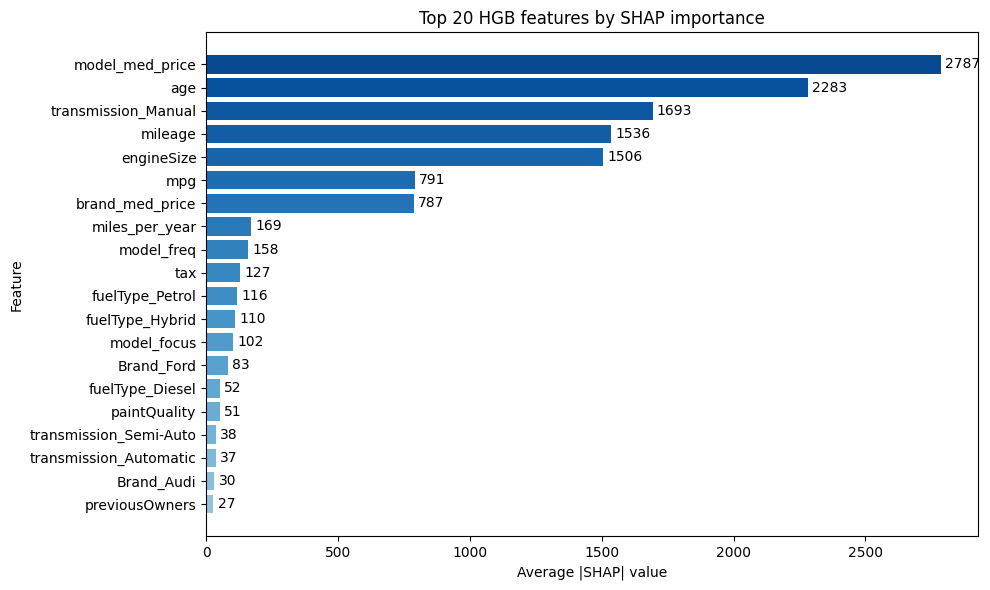

In [31]:
top_k = 20
top_df = shap_importance_df.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_df["feature"], top_df["importance"],
               color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_df))))

ax.set_xlabel("Average |SHAP| value")
ax.set_ylabel("Feature")
ax.set_title(f"Top {top_k} HGB features by SHAP importance")
ax.bar_label(bars, fmt="%.0f", padding=3)
plt.tight_layout()
plt.show()

**Step 3: Automated Feature Selection Optimization**

Now we systematically test different numbers of top features to find the optimal subset. We train the model with the same optimized hyperparameters but using only the most important features identified by SHAP.

In [ ]:
print("\nFeature Selection Analysis with different bins:")

results = []
total_features = len(feature_names_all)

# test every single feature count
# feature_counts = list(range(5, total_features + 1)) 
feature_counts = list(range(16, 20))

# define which bins to *print*
print_bins = {5, 10, 15, 20, 30, 50, 70, 100, total_features}

# use the same processed validation data
X_val_processed = hgb_best.named_steps["preprocess"].transform(X_val)
clean_params = {k.replace("model__", ""): v for k, v in hgb_random.best_params_.items()}

# track best model
best_model = None
best_mae = float("inf")
best_n = None
best_features = None

for n_features in feature_counts:
    # Select top N features
    top_features = shap_importance_df.head(n_features)["feature"].tolist()
    feature_indices = [i for i, fname in enumerate(feature_names_all) if fname in top_features]

    X_train_subset = X_train_processed[:, feature_indices]
    X_val_subset   = X_val_processed[:, feature_indices]

    # Train model
    hgb_selected = HistGradientBoostingRegressor(**clean_params, random_state=42)
    hgb_selected.fit(X_train_subset, y_train)
    pred_subset = hgb_selected.predict(X_val_subset)
    mae_subset = mean_absolute_error(y_val, pred_subset)

    # Save result
    results.append({"n_features": n_features, "mae": mae_subset})

    # Check if it's the best so far
    if mae_subset < best_mae:
        best_mae = mae_subset
        best_n = n_features
        best_model = hgb_selected
        best_features = top_features

    # print only the key bins
    if n_features in print_bins:
        improvement = baseline_mae - mae_subset
        print(f"Top {n_features:3d} features: MAE: {mae_subset:.1f} (Δ: {improvement:+.1f})")

# convert results to DataFrame
results_df = pd.DataFrame(results)

print(f"\nOptimal feature selection results:")
print(f"Best performance with {best_n} features: MAE: {best_mae:.2f}")
print(f"Improvement over baseline: {baseline_mae - best_mae:+.2f} MAE\n")

print(f"Optimal {best_n} features for production model:")
for i, feat in enumerate(best_features, start=1):
    imp = shap_importance_df.loc[shap_importance_df['feature'] == feat, 'importance'].values[0]
    print(f"{i:2d}. {feat:25s} ({imp:.1f})")


Feature Selection Analysis with different bins:

Optimal feature selection results:
Best performance with 16 features: MAE: 1333.32
Improvement over baseline: -7.39 MAE

Optimal 16 features for production model:
 1. model_med_price           (2786.6)
 2. age                       (2283.0)
 3. transmission_Manual       (1693.1)
 4. mileage                   (1535.6)
 5. engineSize                (1506.4)
 6. mpg                       (791.0)
 7. brand_med_price           (787.2)
 8. miles_per_year            (168.9)
 9. model_freq                (158.0)
10. tax                       (127.3)
11. fuelType_Petrol           (116.2)
12. fuelType_Hybrid           (109.5)
13. model_focus               (102.5)
14. Brand_Ford                (82.9)
15. fuelType_Diesel           (51.6)
16. paintQuality              (51.0)


In [0]:
# Save the best model for later use
# Build the final pipeline with feature selection included
def select_best_features(X):
    idx = [i for i, fname in enumerate(feature_names_all) if fname in best_features]
    return X[:, idx]

final_pipe = Pipeline([
    ("preprocess", hgb_best.named_steps["preprocess"]),
    ("feature_selector", FunctionTransformer(select_best_features, validate=False)),
    ("model", best_model)
])

joblib.dump(final_pipe, "hgb_best_feature.pkl")

## RF

**Step 1: Baseline Performance with Optimized Hyperparameters**

In [22]:
# Use the tuned RF pipeline (rf_best_rand) and compute baseline on the validation set
X_val_processed_rf = rf_best_rand.named_steps["preprocess"].transform(X_val)
rf_val_pred = rf_best_rand.named_steps["model"].predict(X_val_processed_rf)
baseline_mae_rf = mean_absolute_error(y_val, rf_val_pred)

print("Baseline Performance of RF model after Hyperparameter Tuning:\n")
print_metrics(y_val, rf_val_pred)

Baseline Performance of RF model after Hyperparameter Tuning:

MAE: 1412.3002 | RMSE: 5607370.6582 | R2: 0.9396


**Step 2: SHAP Feature Importance Analysis**

In [23]:
# Preprocess training data (same preprocessor as in rf_best_rand)
X_train_processed_rf = rf_best_rand.named_steps["preprocess"].transform(X_train)

# Build feature names (log + numeric + OHE categories), same logic as for HGB
feature_names_all_rf = (
    log_features
    + numeric_features
    + list(
        rf_best_rand.named_steps["preprocess"]
        .named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_features)
    )
)

# SHAP for RandomForest (regression)
rf_model = rf_best_rand.named_steps["model"]
explainer_rf = shap.TreeExplainer(rf_model)

# Sample up to 1000 rows
np.random.seed(42)
sample_size_rf = min(50, len(X_train_processed_rf))
sample_idx_rf = np.random.choice(len(X_train_processed_rf), sample_size_rf, replace=False)
X_sample_rf = X_train_processed_rf[sample_idx_rf]

print(f"Computing SHAP values for RF on {sample_size_rf} samples...")
shap_values_rf = explainer_rf.shap_values(X_sample_rf)

# Global importance = mean absolute SHAP
feature_importance_rf = np.abs(shap_values_rf).mean(axis=0)

shap_importance_df_rf = (
    pd.DataFrame({
        "feature": feature_names_all_rf,
        "importance": feature_importance_rf
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 20 most important RF features:")
print(shap_importance_df_rf.head(20).to_string(index=False))

Computing SHAP values for RF on 50 samples...

Top 20 most important RF features:
               feature  importance
       model_med_price 1398.329230
                   age 1348.118661
               mileage 1220.352024
            engineSize 1215.337785
   transmission_Manual 1081.258026
       brand_med_price  881.894138
          brand_anchor  812.974235
        miles_per_year  775.787807
                   tax  763.812532
                   mpg  708.843037
transmission_Semi-Auto  364.586770
            model_freq  312.960945
        Brand_Mercedes  247.424774
       fuelType_Petrol  233.681400
transmission_Automatic  213.449175
            Brand_Opel  197.846316
            Brand_Audi  128.184270
         model_s class  106.270047
           model_focus  101.616759
       fuelType_Diesel   89.195591


**Step 3: Automated Feature Selection Optimization**

In [ ]:
print("\nRF Feature Selection Analysis with different bins:")

results_rf = []

# Use the same processed validation data
X_val_processed_rf = rf_best_rand.named_steps["preprocess"].transform(X_val)

# Reuse tuned RF hyperparameters (strip 'model__' as we instantiate the bare estimator)
rf_params = {k.replace("model__", ""): v for k, v in rf_random.best_params_.items()}

# Track best model
best_model_rf = None
best_mae_rf = float("inf")
best_n_rf = None
best_features_rf = None

# Candidate feature counts (mirror HGB style; adjust if you want to sweep wider)
# feature_counts_rf = list(range(5, total_features + 1)) 
feature_counts_rf = list(range(16, 30))
print_bins_rf = {5, 10, 15, 20, 30, 50, 70, 100, len(feature_names_all_rf)}

for n_features in feature_counts_rf:
    # Select top N features
    top_features_rf = shap_importance_df_rf.head(n_features)["feature"].tolist()
    feature_indices_rf = [i for i, fname in enumerate(feature_names_all_rf) if fname in top_features_rf]

    X_train_subset_rf = X_train_processed_rf[:, feature_indices_rf]
    X_val_subset_rf   = X_val_processed_rf[:, feature_indices_rf]

    # Train RF with the same tuned params
    rf_selected = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)
    rf_selected.fit(X_train_subset_rf, y_train)
    pred_subset_rf = rf_selected.predict(X_val_subset_rf)
    mae_subset_rf = mean_absolute_error(y_val, pred_subset_rf)

    # Save result
    results_rf.append({"n_features": n_features, "mae": mae_subset_rf})

    # Best so far?
    if mae_subset_rf < best_mae_rf:
        best_mae_rf = mae_subset_rf
        best_n_rf = n_features
        best_model_rf = rf_selected
        best_features_rf = top_features_rf

    # Optional summary for key bins
    if n_features in print_bins_rf:
        improvement_rf = baseline_mae_rf - mae_subset_rf
        print(f"Top {n_features:3d} features: MAE: {mae_subset_rf:.1f} (Δ: {improvement_rf:+.1f})")

results_rf_df = pd.DataFrame(results_rf)

print(f"\nOptimal RF feature selection results:")
print(f"Best performance with {best_n_rf} features: MAE: {best_mae_rf:.2f}")
print(f"Improvement over baseline: {baseline_mae_rf - best_mae_rf:+.2f} MAE\n")

print(f"Optimal {best_n_rf} RF features for production model:")
for i, feat in enumerate(best_features_rf, start=1):
    imp = shap_importance_df_rf.loc[shap_importance_df_rf['feature'] == feat, 'importance'].values[0]
    print(f"{i:2d}. {feat:25s} ({imp:.1f})")


RF Feature Selection Analysis with different bins:
Top  20 features: MAE: 1343.5 (Δ: +68.8)

Optimal RF feature selection results:
Best performance with 16 features: MAE: 1335.84
Improvement over baseline: +76.46 MAE

Optimal 16 RF features for production model:
 1. model_med_price           (1398.3)
 2. age                       (1348.1)
 3. mileage                   (1220.4)
 4. engineSize                (1215.3)
 5. transmission_Manual       (1081.3)
 6. brand_med_price           (881.9)
 7. brand_anchor              (813.0)
 8. miles_per_year            (775.8)
 9. tax                       (763.8)
10. mpg                       (708.8)
11. transmission_Semi-Auto    (364.6)
12. model_freq                (313.0)
13. Brand_Mercedes            (247.4)
14. fuelType_Petrol           (233.7)
15. transmission_Automatic    (213.4)
16. Brand_Opel                (197.8)


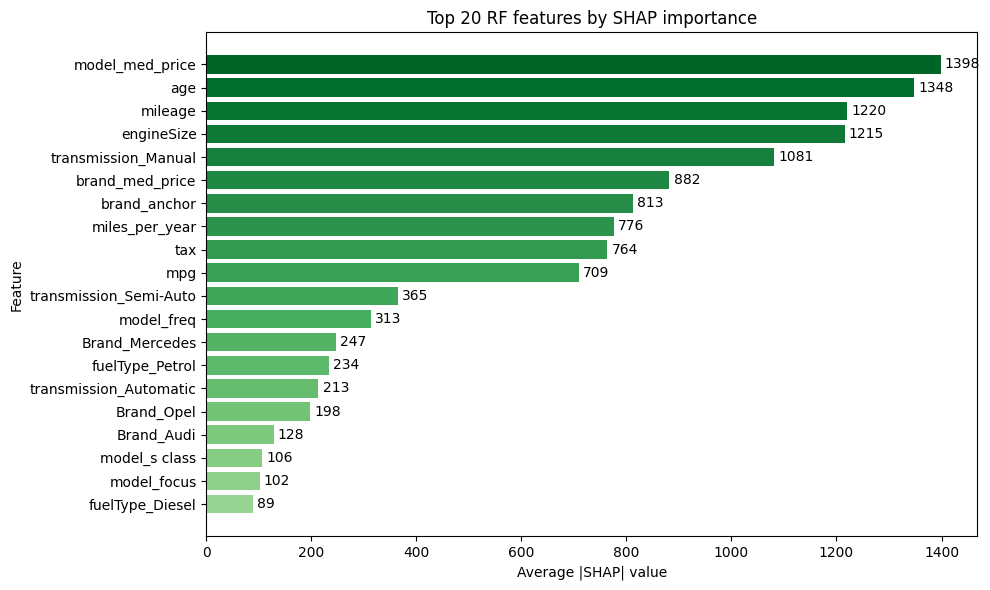

In [25]:
# RF SHAP bar plot
top_k = 20
top_df = shap_importance_df_rf.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    top_df["feature"],
    top_df["importance"],
    color=plt.cm.Greens(np.linspace(0.4, 0.9, len(top_df)))  # andere Farbe für RF
)

ax.set_xlabel("Average |SHAP| value")
ax.set_ylabel("Feature")
ax.set_title(f"Top {top_k} RF features by SHAP importance")
ax.bar_label(bars, fmt="%.0f", padding=3)
plt.tight_layout()
plt.show()

In [ ]:
# Save the best RF model for later use

# Build the final RF pipeline with feature selection included
def select_best_features_rf(X):
    idx = [i for i, fname in enumerate(feature_names_all_rf) if fname in best_features_rf]
    return X[:, idx]

final_rf_pipe = Pipeline([
    ("preprocess", rf_best_rand.named_steps["preprocess"]),
    ("feature_selector", FunctionTransformer(select_best_features_rf, validate=False)),
    ("model", best_model_rf)
])

# joblib.dump(final_rf_pipe, "rf_best_feature.pkl")

### 7. Kaggle Competition

Extra Task (1 Point): Be in the Top 5 Groups on Kaggle

In [0]:
# Load best Models from Joblib

hgb_best_99 = joblib.load("hgb_best_feature.pkl")

In [0]:
# Pick best model and predict on test:

df_cars_test['price'] = hgb_best_99.predict(df_cars_test)

df_cars_test['price'].to_csv('Group05_Version03.csv', index=True) # currently version 3

In [0]:
!kaggle competitions submit -c cars4you -f Group05_Version03.csv -m "Message"

In [0]:
!kaggle competitions submissions -c cars4you